### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [1]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 20    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
# if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')
# var_ckpt = '/root/data_new/zejia/workspace/psl/var/VAR/local_output/ar-ckpt-last.pth'
# var_ckpt = '/root/data_new/zejia/workspace/psl/var/VAR/local_output_60000/ar-ckpt-last.pth'
# var_ckpt = '/root/data_new/zejia/workspace/psl/var/VAR/local_output_big/ar-ckpt-best.pth'
var_ckpt = '/root/data_new/zejia/workspace/psl/var/VAR/local_output_big/ar-ckpt-last.pth'

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    # vae, var = build_vae_var(
    #     V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    #     device=device, patch_nums=patch_nums,
    #     num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    # )
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
var_ckpt_loaded = torch.load(var_ckpt, map_location='cpu')
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(var_ckpt_loaded['trainer']['var_wo_ddp'], strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')
epoch = var_ckpt_loaded['epoch']
iters = var_ckpt_loaded['iter']
print(f'ckpt_ep: {epoch}, ckpt_iter: {iters}')


[constructor]  ==== flash_if_available=True (20/20), fused_if_available=True (fusing_add_ln=0/20, fusing_mlp=0/20) ==== 
    [VAR config ] embed_dim=1280, num_heads=20, depth=20, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0833333 (tensor([0.0000, 0.0044, 0.0088, 0.0132, 0.0175, 0.0219, 0.0263, 0.0307, 0.0351,
        0.0395, 0.0439, 0.0482, 0.0526, 0.0570, 0.0614, 0.0658, 0.0702, 0.0746,
        0.0789, 0.0833]))

[init_weights] VAR with init_std=0.0161374
prepare finished.
ckpt_ep: 30, ckpt_iter: 0


In [2]:
import clip

text = ('a dog', 'a group of people sitting under an umbrella',
        'a human face with a hat',
        'A serene meadow at sunrise, with mist gently rising from the ground',
        'An abandoned city reclaimed by nature, with vines creeping up the skyscrapers',
        'A futuristic metropolis bustling with flying vehicles and neon lights',
        'A cozy cabin nestled in a snowy forest, smoke billowing from the chimney',
        'A magical garden filled with vibrant flowers and whimsical creatures',
        'A vast desert landscape with towering sand dunes and a lone camel caravan',
        'An underwater world teeming with colorful coral reefs and exotic fish',
        'A mystical castle perched on a cliff overlooking a turbulent sea',
        'A bustling marketplace in an ancient, cobblestone-lined city',
        'A fantastical realm where floating islands drift among cotton candy clouds',
        'A futuristic space station orbiting a distant planet, with sleek, metallic architecture',
        'a dog playing a computer',
        'a teddy bear on a skateboard in times square')

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-L/14", device=device)
text = clip.tokenize(text).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)


100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 77.7MiB/s]


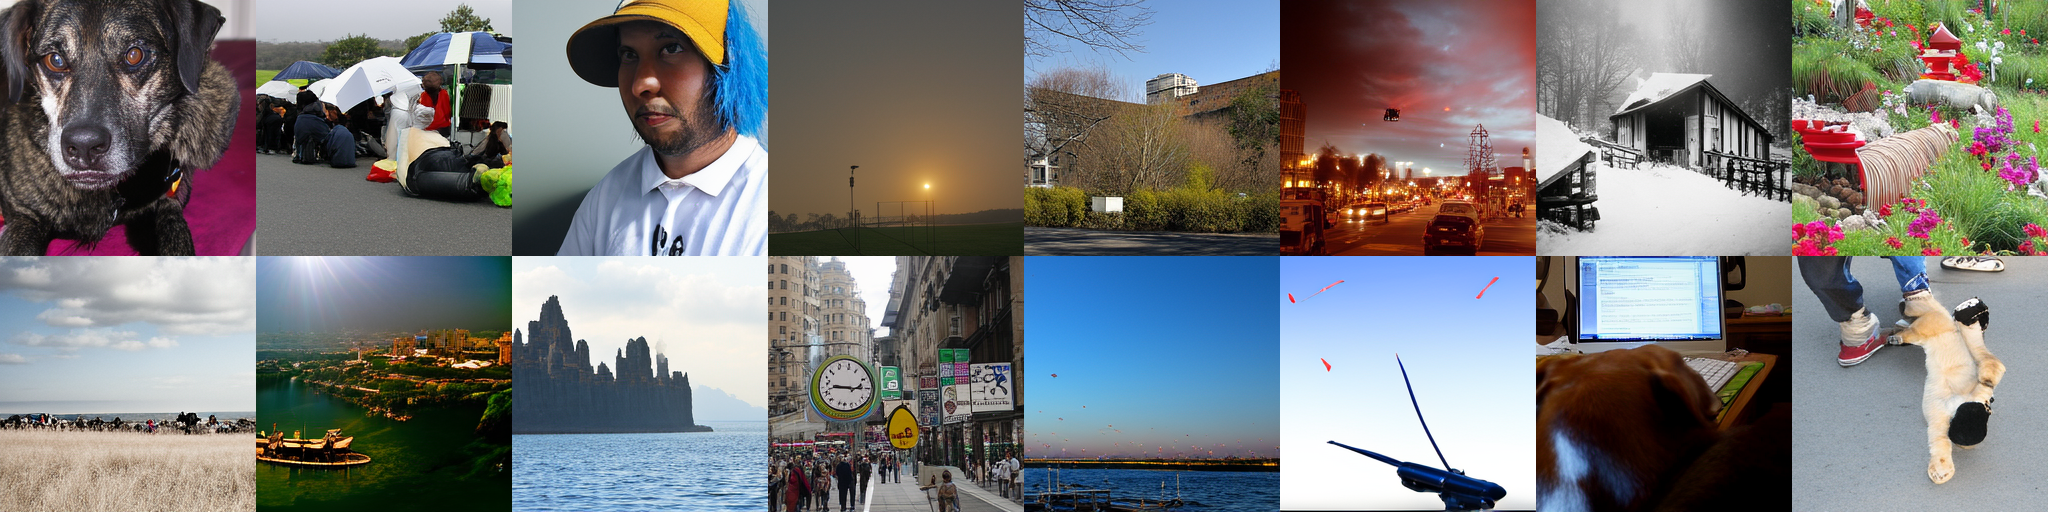

In [3]:
############################# 2. Sample with classifier-free guidance

# set args
seed = 1103 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
# cfg_list = [1.5, 2, 2.5, 3, 3.5, 4, 6, 8, 10] #@param {type:"slider", min:1, max:10, step:0.1}
cfg_list = [3.5]
# class_labels = (980, 980, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
# B = len(class_labels)
# label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
B = text_features.shape[0]

for cfg in cfg_list:
    with torch.inference_mode():
        with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
            # recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)
            recon_B3HW = var.autoregressive_infer_cfg(B=B, text_features_BD=text_features, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

    chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
    chw = chw.permute(1, 2, 0).clone().mul_(255).cpu().numpy()
    chw = PImage.fromarray(chw.astype(np.uint8))
    chw.show()


In [ ]:
import torch
from utils.data import build_dataset
from PIL import Image as PImage
import numpy as np
import clip
import torch.nn as nn
import os.path as osp
from tqdm import tqdm
from torch.utils.data import DataLoader

def show_img(img):
    img = img.permute(1, 2, 0).mul_(255).cpu().numpy()
    img = PImage.fromarray(img.astype(np.uint8))
    img.show()

In [ ]:
DATA_ROOT = r"/root/data_new/zejia/workspace/psl/var/datasets/COCO2017"
train_set, val_set = build_dataset(data_path=DATA_ROOT, final_reso=224, hflip=False, mid_reso=1.125)
# show_img(train_set[0][0])
# print(train_set[0][0].shape, train_set[0][1])
# show_img(val_set[0][0])
# print(val_set[0][0].shape, val_set[0][1])
# define the dataloader
train_loader = DataLoader(train_set, batch_size=64, shuffle=False, num_workers=0)